# 6/24 SunSpots

Playing 100 samples of each sin wave. Each sin wave corresponds to one day's worth of sunspot data, taking the number of sunspots plus the frequency 220hz, we end up with a clip of audio that cycles through 73k different sounds

In [1]:
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, decimate
from scipy import interpolate
from sklearn.decomposition import PCA
import sys
import time
from FreqMod import *
sys.path.append("..")
from SlidingWindow import *
from CurvatureTools import *
from Sunspot import *
%matplotlib notebook

<IPython.core.display.Javascript object>


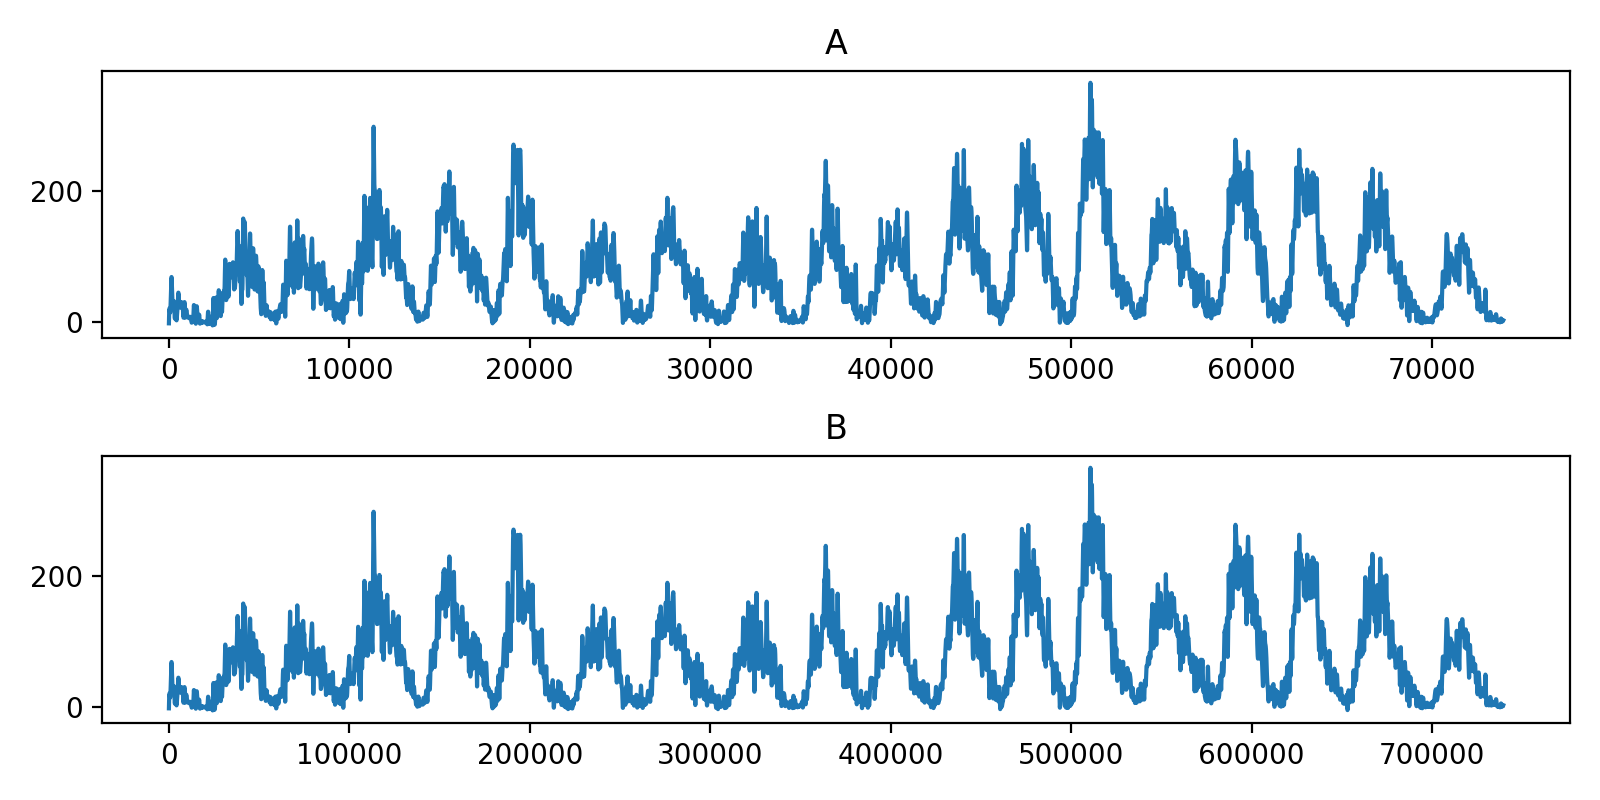

In [2]:
A = extractData()
decfac = 30 # How much I'm decimating (downsampling after smoothing)
fac = 10

decleft = decfac
decdone = 1
while decleft > 1:
    dec = min(decleft, 10)
    A = decimate(A, dec)
    decdone *= dec
    decleft = int(decleft / dec)
A = interpData(A, decdone)
B = interpData(A, fac)

plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.plot(A)
plt.title("A")
plt.subplot(2, 1, 2)
plt.plot(B)
plt.title("B")
plt.tight_layout()

fs = 44100
ipd.Audio(B,rate=fs)

<IPython.core.display.Javascript object>


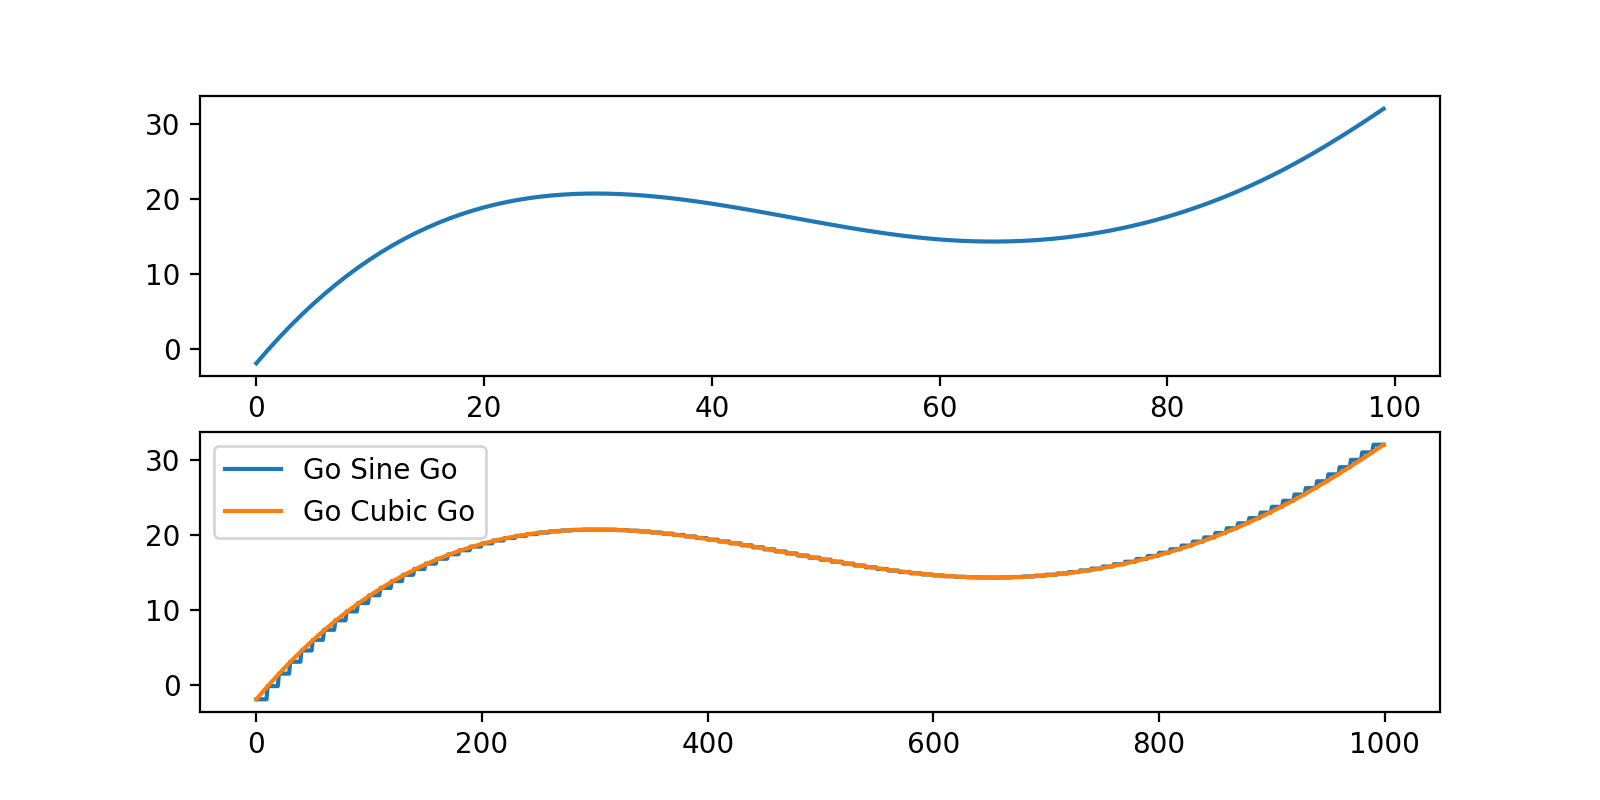

In [3]:
x = A[0:100]
xb = goSinGo(x)
xc = interpData(x, 10)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(x)
plt.subplot(212)
plt.plot(xb)
plt.plot(xc)
plt.legend(["Go Sine Go", "Go Cubic Go"])

<IPython.core.display.Javascript object>


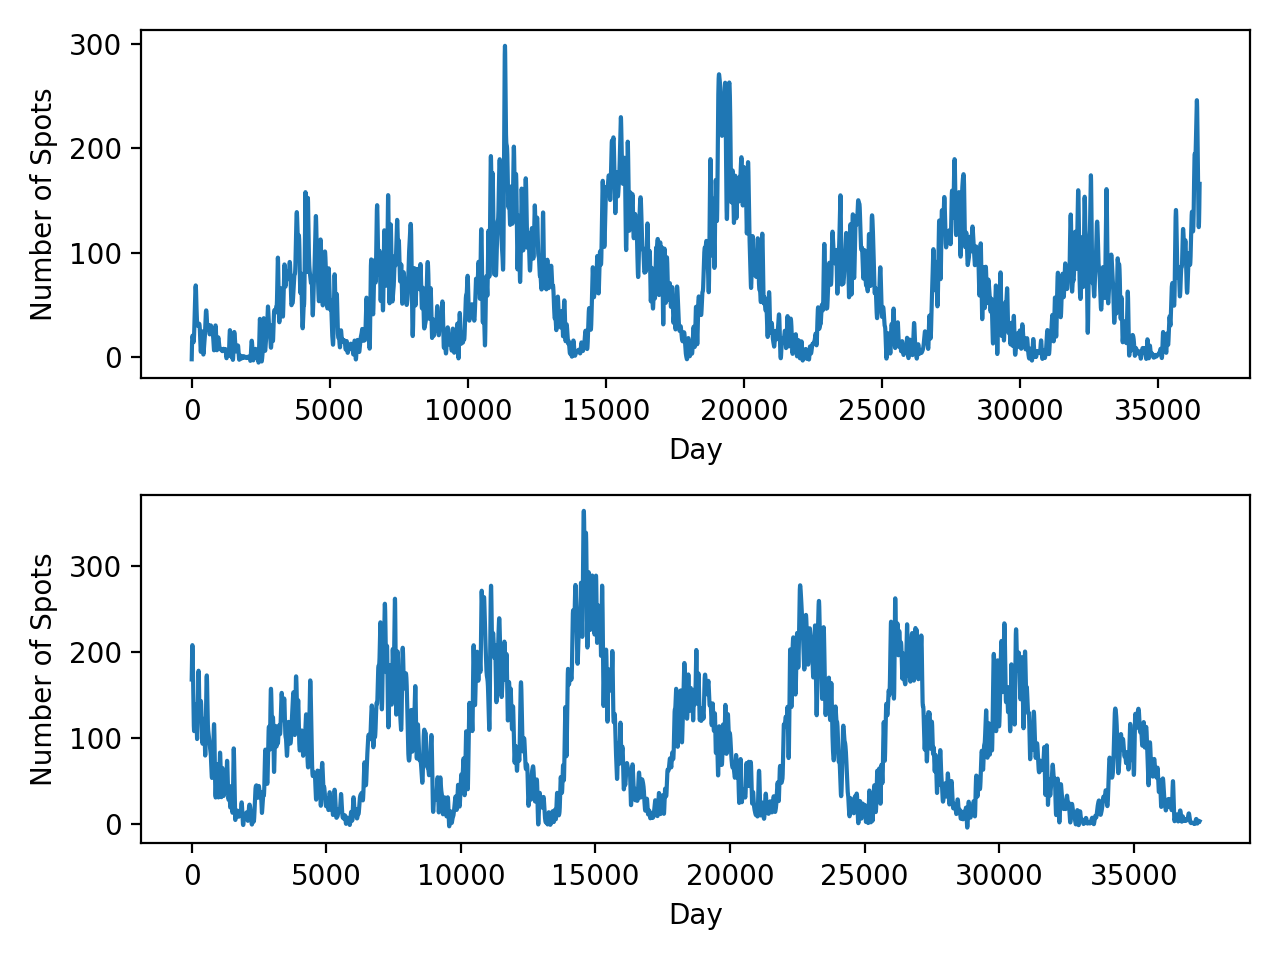

In [4]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(A[0:36500])
plt.xlabel("Day")
plt.ylabel("Number of Spots")
plt.subplot(2,1,2)
plt.plot(A[36500:len(A)])
plt.xlabel("Day")
plt.ylabel("Number of Spots")
plt.tight_layout()

# 6/25 Sunspots with interpolation

So see if you can do something similar and make x your sunspot and stretch out the sampling enough so that it occurs over 10 seconds or something

Try using the scipy interp function to stretch it out quickly

In [5]:
440*(2*2*2*2)

7040

In [32]:
dim = 40
Tau = 800
dT = 1

tic = time.time()
X = getSlidingWindow(B,dim,Tau,dT)
toc = time.time()
print("Elapsed Time Sliding Window:", toc-tic)

dcom = 3
pca = PCA(n_components = dcom)
Y = pca.fit_transform(X)


intervals = np.sqrt(pca.explained_variance_)
intervals = np.concatenate(([0], intervals))
intervals = np.cumsum(intervals)
intervals = intervals / intervals[-1]
freqs = 110*(2**(intervals*3))
for i in range(len(freqs)-1):
    print("Dimension {}: {} - {}".format(i, freqs[i], freqs[i+1]))
'''
plt.figure()
plt.stem(freqs)
plt.ylabel("Frequency (hz)")
plt.xlabel("Endpoint")
'''


# Estimate the derivative of each column using a smoothing factor
# that's the same as the decimation factor
YDeriv = getCurvVectors(Y, 1, decfac)[1]
YInteg = np.cumsum(Y, axis=0) # Take discrete integral of each column
YIntegDeriv = getCurvVectors(YInteg, 1, decfac)[1]


#F = apply_freq_mod(YIntegDeriv,freqs,decfac,dcom)
#print(F)
'''
plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(Y)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("PCA of Sliding Window")
plt.subplot(312)
plt.plot(YDeriv)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("Derivative of PCA of Sliding Window")
plt.subplot(313)
plt.plot(F[0:10000])
plt.title("Frequency modulation, First 10000 Samples")
plt.tight_layout()
'''

fs = 44100
#ipd.Audio(F,rate=fs)

Elapsed Time Sliding Window: 0.35144782066345215
Dimension 0: 110.0 - 261.4903280616017
Dimension 1: 261.4903280616017 - 555.1848775556039
Dimension 2: 555.1848775556039 - 880.0


In [33]:
fM = np.zeros(len(Y))

for i in range(len(freqs)-1):
    minF = np.min(Y[:,i])
    maxF = np.max(Y[:,i])
    print(minF,maxF)
    
    setSize = np.absolute(minF) + np.absolute(maxF)
    freqsSize = freqs[i+1] - freqs[i]
    scaleSize = setSize/freqsSize
    Y[:,i] = Y[:,i] / scaleSize
    
    newminF = np.min(Y[:,i])
    newmaxF = np.max(Y[:,i])
    print(newminF,newmaxF)
    offsetSize = np.absolute(newminF) + freqs[i]
    Y[:,i] += offsetSize
    
    MIF = np.min(Y[:,i])
    MAF = np.max(Y[:,i])
    print(MIF,MAF)
    
YInteg = np.cumsum(Y, axis=0)/44100

for i in range(len(freqs)-1):
    fM = fM + np.cos(2*np.pi*YInteg[:,i])


'''    
for i in range(tD.shape[1]):
    minF = np.min(tD[:,i])
    maxF = np.max(tD[:,i])
'''


-618.8881141478633 627.1221226166194
-75.24461732284084 76.24571073876086
110.0 261.4903280616017
-365.4599072292083 717.6956408438782
-99.09341553274281 194.60113396125934
261.4903280616017 555.1848775556039
-312.4961667339189 448.33045463489964
-133.4121044272417 191.40301801715444
555.1848775556039 880.0


'    \nfor i in range(tD.shape[1]):\n    minF = np.min(tD[:,i])\n    maxF = np.max(tD[:,i])\n'

In [35]:
ipd.Audio(fM,rate=fs)

# $ s(t) = \cos(2 \pi f(t)) $

## Frequency $\nu = f'(t)$ in units of cycles / sec

## Ex) f(t) = kt

## $s(t) = \cos(2 \pi k t)$

In [ ]:
fs = 44100
duration = 2
t = np.arange(duration*fs) / fs
y = np.cos(2*np.pi*t)

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(Y)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("PCA of Sliding Window")
plt.subplot(312)
plt.plot(YInteg)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("Integral (Cumulative Sum) of PCA of Sliding Window")
plt.subplot(313)
plt.plot(YIntegDeriv)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("Derivative of Integral of PCA of Sliding Window")
plt.tight_layout()

In [ ]:
Z = Y[0::fac, :]
print(Z.shape)
plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], c=np.arange(Z.shape[0]))
plt.title("2D PCA")
plt.axis('equal')

In [ ]:
# 3D Plot (will be slow to render for B)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=np.arange(Z.shape[0]))